# Notebook 3: Dealing with Multicolinearity

Before trying to change the model, we want to reduce the data set we are using. A common heuristic recommends 10 data points per feature for regression. Additionaly, we have similar and thus highly correlated features. Therefore, we decided to reduce the number of features from 120 to 15/30. 

We tried two different criteria for selecting remaining features: the total amount of correlation and the Variance inflation factor (VIF).

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import glob
import pandas as pd
import sklearn
from src import corr_utils as corr_utils
from src import ana_utils as ana_utils
import collections
import scipy.stats


#np.set_printoptions(suppress=True)
from sklearn.linear_model import LinearRegression

np.random.seed(7)

Import datasets that were preprocessed in Notebook 1

In [11]:
wb_data = pd.read_csv("data/wb_data.csv", index_col="Country Name")
wb_data_short = pd.read_csv("data/wb_data_short.csv", index_col="Country Name")
whr_data = pd.read_csv("data/whr_data.csv", index_col="Country name")

### Sighting Correlation 

First, we wanted to get a first impression of the amount of multicolinearity present in the data. Therefore, we created a correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix')

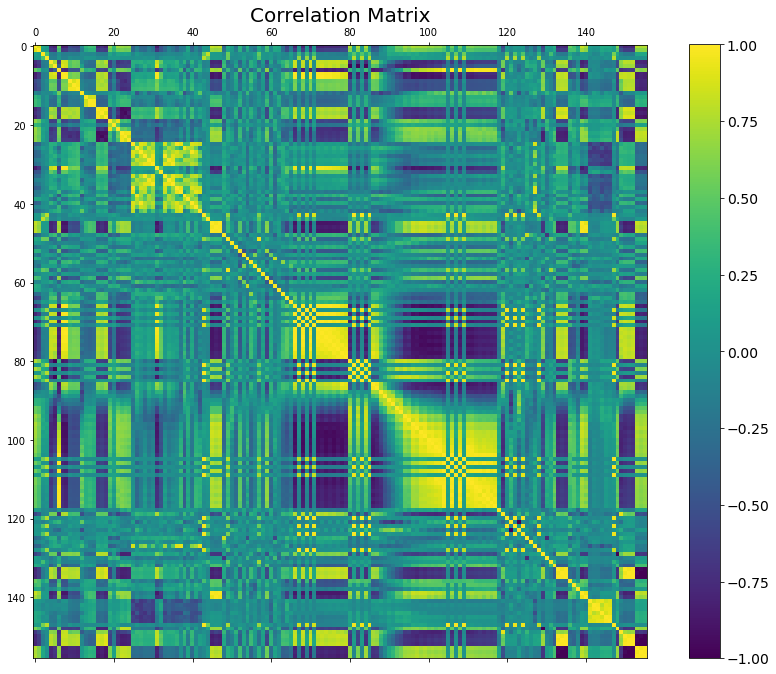

In [12]:
indicator_corr = wb_data.corr(method="pearson")

f = plt.figure(figsize=(15, 11))
plt.matshow(indicator_corr, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)

### Pearson's r indicator removal

Since we have multiple cluster of correlated features, we wondered what these clusters are. We build a function that returns a dict of indicators and their total correlation measured by Pearson's r (sum of absolute correlation coefficients across all the other indicators). 

In [13]:
corr_dict = ana_utils.corr_counter(indicator_corr)
corr_dict_sorted = sorted(corr_dict.items(), key=lambda x: x[1], reverse=True) 
#corr_dict_sorted


Since we do not want to remove a complete cluster, which could happen if we just threw out a big chunk of the correlated data, we decided on an iterative procedure that removes indicators one-by-one until the data is reduced to the desired number of indicators.

In [14]:
wb_data_pear_reduced_15 = corr_utils.pearsons_reduction(wb_data, 15)
wb_data_pear_reduced_30 = corr_utils.pearsons_reduction(wb_data, 30)

In [ ]:
least_squares = sklearn.linear_model.LinearRegression()
test_size = 30
wb_data_rand_15_list = []
wb_data_rand_30_list = []

for i in range(0, 5):
    wb_data_rand_reduced_15 = wb_data.sample(15, axis=1)
    print(wb_data_pear_reduced_15.shape)
    wb_data_rand_15_list.append(wb_data_rand_reduced_15)

    wb_data_rand_reduced_30 = wb_data.sample(30, axis=1)
    wb_data_rand_30_list.append(wb_data_rand_reduced_30)
    print("Random Indicators Sample", i+1)

    loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=least_squares, n=2000, data=wb_data_rand_reduced_15, gt=whr_data, test_size=test_size, scaling="normalize")
    print("Mean loss (15 indicators):", mean_loss)
    print("The average size of the first ten coefficients (reduced set of indicators):", avg_coefs[:10])

    loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=least_squares, n=2000, data=wb_data_rand_reduced_30, gt=whr_data, test_size=test_size, scaling="normalize")
    print("Mean loss (30 indicators):", mean_loss)
    print("The average size of the first ten coefficients (reduced set of indicators):", avg_coefs[:10])

(150, 15)
Random Indicators Sample 1
Mean loss (15 indicators): 0.5157627973538254
The average size of the first ten coefficients (reduced set of indicators): [  3.7383  34.8692  21.9838 -15.2439 -19.9746 -16.5643 -19.168   -6.6257
   1.9458 -18.3272]
Mean loss (30 indicators): 0.44376457528028934
The average size of the first ten coefficients (reduced set of indicators): [  1.0813  -1.2843 -55.1945  -2.5751 -29.7907  41.2493  20.2274   8.7719
 -13.3167   2.6237]
(150, 15)
Random Indicators Sample 2
Mean loss (15 indicators): 0.5771549798427121
The average size of the first ten coefficients (reduced set of indicators): [34.3619  4.0334 -2.7771 -6.8444  1.335  -2.8044 -2.1854  6.366  -8.7043
 24.3703]
Mean loss (30 indicators): 0.7900200981876287
The average size of the first ten coefficients (reduced set of indicators): [-0.7211 51.7369  4.7105  0.1169 -1.0866 -0.5536  4.6256  2.4253 21.3969
 -5.4439]
(150, 15)
Random Indicators Sample 3
Mean loss (15 indicators): 0.3606505013240996
Th

In [ ]:
least_squares = sklearn.linear_model.LinearRegression()
test_size = 30

loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=least_squares, n=2000, data=wb_data_pear_reduced_15, gt=whr_data, test_size=test_size, scaling="normalize")
print("Mean loss (15 indicators):", mean_loss)
print("STD of the Loss:", np.std(loss_list))
print("The average size of the first five coefficients (reduced set of indicators):", avg_coefs[:5], "\n")

loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=least_squares, n=2000, data=wb_data_pear_reduced_30, gt=whr_data, test_size=test_size, scaling="normalize")
print("Mean loss (30 indicators):", mean_loss)
print("STD of the Loss:", np.std(loss_list))
print("The average size of the first five coefficients (reduced set of indicators):", avg_coefs[:5], "\n")

Mean loss (15 indicators): 3.5479052574334937
The average size of the first ten coefficients (reduced set of indicators): [ 2.7725  3.7545  1.6153  1.3434 -5.6904 -3.499  -3.6507  0.0655  7.7635
  1.1901]
Mean loss (30 indicators): 1.0930323551391432
The average size of the first ten coefficients (reduced set of indicators): [ 1.5576  0.372   1.2519  0.5168 -2.9936 -4.7559  0.8911 -0.4959 -8.2461
  1.4889]


While the results improve a lot compared to Linear Regression on the full data 

### VIF indicator removal

Our second approach instead uses the variance inflation factor to, again, iteratively remove indicators from the data set.

In [ ]:
wb_data_vif_reduced_15 = corr_utils.vif_reduction(wb_data, 1, 15)
wb_data_vif_reduced_30 = corr_utils.vif_reduction(wb_data, 1, 30)

In [ ]:
loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=least_squares, n=2000, data=wb_data_vif_reduced_15, gt=whr_data, test_size=test_size, scaling="normalize")
print("Mean loss (15 indicators):", mean_loss)
print("STD of the Loss:", np.std(loss_list))
print("The average size of the first five coefficients (reduced set of indicators):", avg_coefs[:5], "\n")

loss_list, mean_loss, coef_list, avg_coefs = ana_utils.n_fold_ceval(reg_model=least_squares, n=2000, data=wb_data_vif_reduced_30, gt=whr_data, test_size=test_size, scaling="normalize")
print("Mean loss (30 indicators):", mean_loss)
print("STD of the Loss:", np.std(loss_list))
print("The average size of the first five coefficients (reduced set of indicators):", avg_coefs[:5], "\n")

Mean loss (15 indicators): 1.7606703570066633
The average size of the first ten coefficients (reduced set of indicators): [-0.6257 -6.9856  3.2427 39.4997  0.697  -3.9842 -0.4977 -2.3482 -0.2918
  0.2886]
Mean loss (30 indicators): 0.8537281652848513
The average size of the first ten coefficients (reduced set of indicators): [ 1.194  -0.8856 -3.7867 -5.9833  0.3094  0.0757 -1.6814 11.3202  0.9476
 -3.3362]


### Baseline Reduction

To have a baseline comparison for our reduced data sets, we create 5 data sets with 15/30 randomly selected indicators.

In [ ]:
ind_removal_sim([1, 5, 10, 20, 25], 10, sklearn.linear_model.LinearRegression(), 1000, wb_data, whr_data)

## Export reduced datasets
Lastly, we export our reduced datasets so we can test them on other models later on.

In [ ]:
wb_data_pear_reduced_15.to_csv("data/wb_data_pear_reduced_15.csv", index=False)
wb_data_pear_reduced_30.to_csv("data/wb_data_pear_reduced_30.csv", index=False)
wb_data_vif_reduced_15.to_csv("data/wb_data_vif_reduced_15.csv", index=False)
wb_data_vif_reduced_30.to_csv("data/wb_data_vif_reduced_30.csv", index=False)